# **OPTIMIZING LOAN APPROVALS**
### **A Data-Driven Model For Assessing Installment-to-Income Risk**

*A DSCI 550 Group Project (Spring 2024)*

**Created by**
- Jinwen “Eddie” Zhao
- Jackson Crawford
- Cameron Ela
- Ravish Kamath

## Problem Definition

**Objective**
- Improve loan default for peer-to-peer loans (LendingClub)

**Background**
- Current models underperforming negatively affecting loan decision-making. Non-gurantee of future results. (Cornell 2020 Study)

**Task**
- Develop an advanced model to predict default probabilities including both quantitative and behaviorial factors.

**Goal**
- Refine loan approval criteria to manage risk effectively.



### Background

This project aims to significantly enhance the accuracy of loan default predictions for peer-to-peer loans facilitated by LendingClub. The predictive models employed are suboptimal, leading to ineffective loan decision-making processes. There are significant limitations to existing models and their inability to ensure reliable future results. In response, our task involves the development of an advanced model that not only incorporates traditional quantitative financial data but also integrates behavioral factors that might affect default probabilities. This comprehensive approach aims to produce a more robust model that better predicts defaults. The ultimate goal of this initiative is to refine and improve the criteria for loan approvals, thus managing risk more effectively. By doing so, we intend to enhance the stability of financial outcomes for lenders and borrowers on the LendingClub platform, thereby strengthening the reliability and efficiency of the peer-to-peer lending model.

### Question and Hypothesis

***Does a higher installment-to-income ratio increase the likelihood of loan defaults on the LendingCLub platform?***

**Hypothesis**:
- The ratio of loan installments to annual income is directly associated with an increased risk of loan default, suggesting that borrowers whose loan repayments constitute a larger fraction of their income are more prone to financial distress, leading to a higher probability of default.

## Description of Dataset

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### FOR GOOGLE COLLAB CONNECTION
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# # Reading the loan_light.csv file
#
# loan_light = pd.read_csv("/content/drive/MyDrive/DSCI550_project/loan_light.csv")
# loan = loan_light   # Make a hard copy of the database called "loan" so it doesn't get messed up afterward
# columns = loan.columns
# loan.head()

In [5]:
loan_light = pd.read_csv("loan_light.csv")
# Make a hard copy of the database called "loan" so it doesn't get messed up afterward
loan = loan_light.copy()
print(loan.shape)
loan_light.head()

(5000, 21)


,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
0,80000.0,Individual,6746.0,0.0,0.0,15.12,10,B,1.0,743.75,...,1.0,0.0,OWN,36,0.0,0.0,debt_consolidation,2016,1,principal
1,60000.0,Individual,13623.0,0.0,0.0,12.32,7,D,0.0,286.73,...,3.0,0.0,MORTGAGE,60,1.0,0.0,credit_card,2017,0,other
2,78000.0,Individual,11011.0,0.0,0.0,25.00,1,D,6.0,869.66,...,4.0,0.0,MORTGAGE,60,3.0,0.0,debt_consolidation,2015,0,analyst
3,62000.0,Individual,9679.0,0.0,0.0,22.32,9,D,7.0,713.96,...,2.0,0.0,RENT,36,4.0,0.0,debt_consolidation,2017,1,other
4,49000.0,Individual,4925.0,0.0,0.0,32.43,10,D,0.0,366.51,...,4.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2017,1,driver


We obtained the 5,000 loan record dataset from Lending Club. Each data point has 21 features and a “loan default" target variable. The target variable is a binary variable indicating a person's default status. Some features are traditional financial metrics used in loan assessment such as annual income, loan amount, and loan grade. There are also behavioral features such as borrower’s job, employment length, and home ownership. Through several cleaning procedures and variable creation, we divided these variables into categorical, ordinal, discrete, and continuous variables.

The following spreadsheet will be explaining what does each parameter mean. Note that we are interested in the loan_default value.

In [140]:
# loan_param = pd.read_excel('/content/drive/MyDrive/DSCI550_project/loan_param.xlsx')
# loan_param.style.set_properties(subset=['Description'], **{'width': '1000px'})

In [141]:
loan_param = pd.read_excel('loan_param.xlsx')
loan_param.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


## Exploring the Data

EDA steps:
- Variable Identification
- Univariate analysis,
- Bi-variate analysis
- Missing value treatment (no missing values, skip),
- Outlier treatment (WIP),
- Variable transformation/creation

### Variable Identification


**Assigning variables to be categorical, ordinal, continuous and date:**

***Target Variable:***
- loan_default

***Categorical Variables:***
- application_type
- home_ownership
    - Behavioural factor
- purpose
- job
    - Behavioural factor

***Ordinal Variable:***
- grade
- emp_length
  - Behavioural factor

***Discrete Variables:***
- chargeoff_within_12_mths
- delinq_2yrs
- inq_last_12m
- num_actv_bc_tl
- pub_rec_bankruptcies
- term
    - (36 or 60 month term)
- mort_acc
- num_tl_90g_dpd_24m

***Datetime Object:***
- year

***Continous Variables:***
- annual_inc
- avg_cur_bal
- dti
- installment
- loan_amnt

In [142]:
str_cats = ['application_type', 'home_ownership', 'purpose', 'job']
for cols in str_cats:
    loan[cols] = loan[cols].astype('category')

int_cats = ['chargeoff_within_12_mths', 'delinq_2yrs', 'inq_last_12m', 'num_actv_bc_tl',
            'pub_rec_bankruptcies', 'term', 'mort_acc', 'num_tl_90g_dpd_24m']
for cols in int_cats:
    loan[cols] = loan[cols].astype('int')

loan['loan_amnt'] = loan['loan_amnt'].astype('float')

In [143]:
def convert_to_ordinal(char):
    if char.upper() not in 'ABCDEFG':
        return None  # Return None for characters other than A to G
    return ord('G') - ord(char.upper()) + 1  # Convert the character to its reversed ordinal value

loan['grade'] = loan['grade'].apply(lambda x: convert_to_ordinal(x))

# Convert Employment into categories with similar timeframe experience
emp_len_map = {0: "< 1 year",
               1: '1 - 2 years',
               2: '1 - 2 years',
               3: '3 - 5 years',
               4: '3 - 5 years',
               5: '3 - 5 years',
               6: '6 - 9 years',
               7: '6 - 9 years',
               8: '6 - 9 years',
               9: '6 - 9 years',
               10: '10+ years'}
loan['emp_length_cat'] = loan['emp_length'].map(emp_len_map).astype('category')

emp_length_unique_list = [item for index, item in enumerate(emp_len_map.values()) if item not in list(emp_len_map.values())[:index]]

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories= [emp_length_unique_list])
loan['emp_length'] = enc.fit_transform(loan[['emp_length_cat']])
loan['emp_length'] = loan['emp_length'].astype('int')

# Remove to datetime
loan = loan.drop('year', axis= 1)

In [144]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   annual_inc                5000 non-null   float64 
 1   application_type          5000 non-null   category
 2   avg_cur_bal               5000 non-null   float64 
 3   chargeoff_within_12_mths  5000 non-null   int64   
 4   delinq_2yrs               5000 non-null   int64   
 5   dti                       5000 non-null   float64 
 6   emp_length                5000 non-null   int64   
 7   grade                     5000 non-null   int64   
 8   inq_last_12m              5000 non-null   int64   
 9   installment               5000 non-null   float64 
 10  loan_amnt                 5000 non-null   float64 
 11  num_actv_bc_tl            5000 non-null   int64   
 12  pub_rec_bankruptcies      5000 non-null   int64   
 13  home_ownership            5000 non-null   catego

In [145]:
# Showing the average, spread, and the range of continuous variable.
loan.describe().applymap('{:,.2f}'.format)

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,loan_default
count,"5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00"
mean,"79,301.50","13,687.34",0.01,0.32,18.06,2.64,5.20,2.38,447.17,"14,577.06",3.58,0.15,41.73,1.49,0.08,0.23
std,"46,568.05","16,501.18",0.11,0.83,8.75,1.20,1.30,2.45,282.05,"9,234.44",2.33,0.40,10.23,1.76,0.36,0.42
min,"12,000.00",0.00,0.00,0.00,0.00,1.00,1.00,0.00,30.12,"1,000.00",0.00,0.00,36.00,0.00,0.00,0.00
25%,"49,500.00","3,028.75",0.00,0.00,11.49,2.00,4.00,1.00,240.67,"7,337.50",2.00,0.00,36.00,0.00,0.00,0.00
50%,"69,500.00","7,324.50",0.00,0.00,17.26,3.00,5.00,2.00,371.64,"12,000.00",3.00,0.00,36.00,1.00,0.00,0.00
75%,"96,000.00","19,124.00",0.00,0.00,24.24,4.00,6.00,3.00,602.30,"20,000.00",5.00,0.00,36.00,2.00,0.00,0.00
max,"499,000.00","276,618.00",3.00,12.00,49.43,4.00,7.00,19.00,"1,504.85","40,000.00",22.00,6.00,60.00,9.00,4.00,1.00


### Univariate Analysis

Separate target variable (loan default) from feature variables. Additionally, separate numerical features from categorical features for univariate and bivariate analysis.

In [146]:
# separate target and feature
target = pd.DataFrame(loan["loan_default"])
feature = loan.loc[:, loan.columns != 'loan_default']

In [147]:
# # separate categorical, discrete and numerical features
# conts_feat = feature.select_dtypes(include=['float']).columns.tolist()
# disc_feat = feature.select_dtypes(include=['int']).columns.tolist()
# cat_feat = feature.select_dtypes(include=['category']).columns.tolist()
# numerical = feature[conts_feat]
# discrete  = feature[disc_feat]
# categorical = feature[cat_feat]
#
# numerical.shape, discrete.shape, categorical.shape

In [148]:
# print("\nnumerical  :", list(numerical.columns))
# print("\ndiscrete   :", list(discrete.columns))
# print("\ncategorical:", list(categorical.columns))

#### Target Variable

Text(0.5, 0, '')

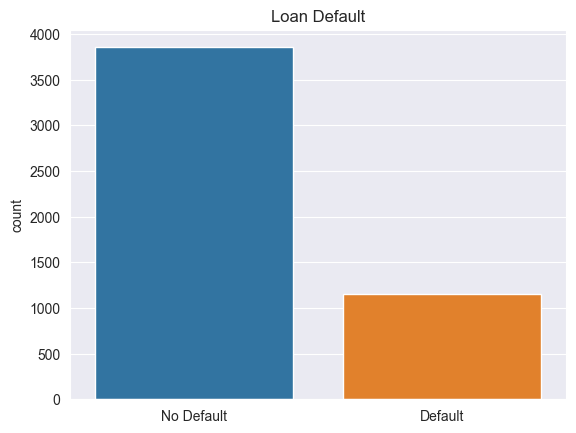

In [149]:
default_plot = sns.countplot(x='loan_default', data = loan)
plt.title("Loan Default")
plt.xticks(ticks=range(len([0,1])), labels=['No Default', 'Default'])
plt.xlabel('')

- We can that around 20-25 percent of all loans in the data set are defaults
- Due to the bias towards non-defaults, we need to consider resampling our dataset to create equal amount of each category.
- Using F1 score for deciding the success of a model would make sense.

In [150]:
(len(loan[loan['loan_default']==1])/ len(loan))*100

22.939999999999998

#### Predictor Variables

##### **Plot distributions for numerical features**

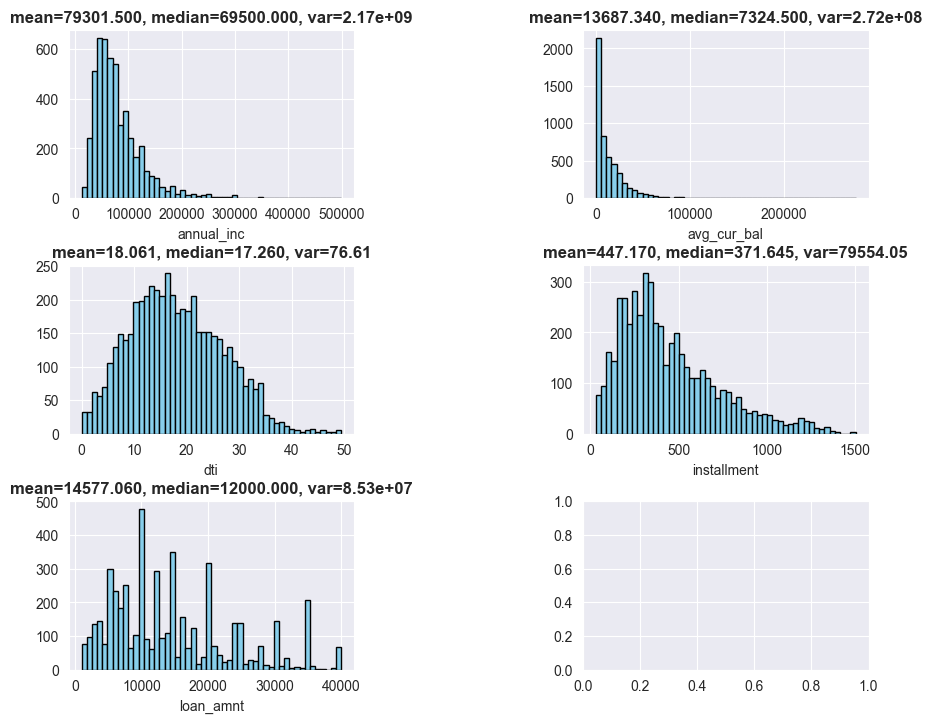

In [151]:
# create figure for numerical feature plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
# Iterate over each data column and plot on each subplot using a for loop

for i, (col, ax) in enumerate(zip(feature.select_dtypes(include=['float']).columns, axes.flatten())):
    mean = loan[col].mean()
    median = loan[col].median()
    var = loan[col].var().round(2)
    if var > 100000:
      var = "{:.2e}".format(var)

    ax.hist(loan[col], bins=50, color='skyblue', edgecolor='black')  # Adjust bins as needed
    ax.set_title(f"mean={mean:.3f}, median={median:.3f}, var={var}", fontweight='bold')
    ax.set_xlabel(col)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.8, hspace=0.4)

- The distributions of these variables are skewed due to their values being strictly positive.
- Will require a log transformation on avg_cur_bal and dti.
- We will see in later analysis that we will not require loan_amnt, and do feature engineering with installment and annual_inc which includes a log transformation.

In [152]:
import numpy as np
loan['avg_cur_bal_log'] = np.log(loan.avg_cur_bal + 1)
loan['dti_log'] = np.log(loan.dti + 1)

#### **Focus: Annual Income**


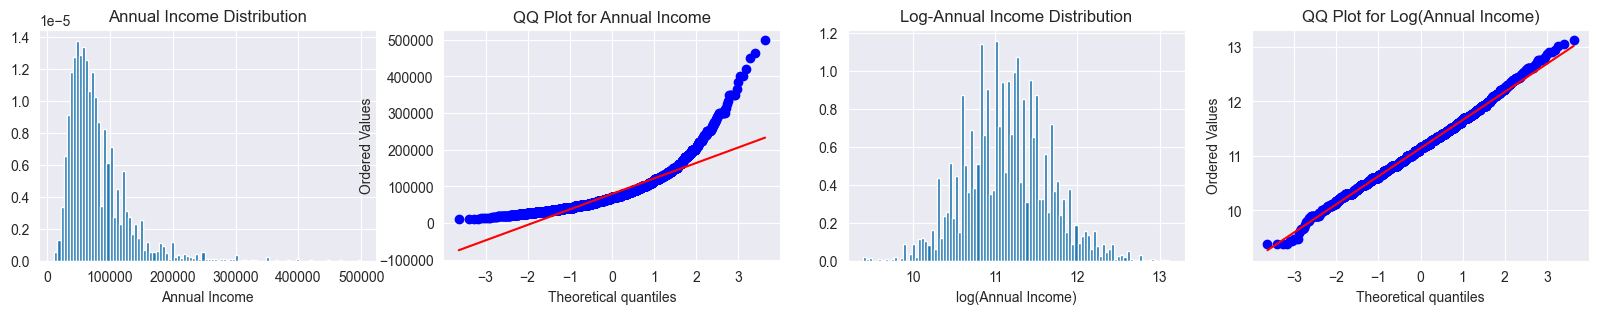

In [153]:
import numpy as np
import seaborn as sns

loan['annual_inc_log'] = np.log(loan.annual_inc)

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(20,3))

# Annual Income Histogram
axs[0].hist(loan['annual_inc'], bins=100, density=True)
axs[0].set_title("Annual Income Distribution")
axs[0].set_xlabel("Annual Income")

from scipy import stats
stats.probplot(loan['annual_inc'], dist="norm", plot=axs[1])
axs[1].set_title('QQ Plot for Annual Income')

# Log of Annual Income Histogram
axs[2].hist(loan['annual_inc_log'], bins=100, density=True)
axs[2].set_title("Log-Annual Income Distribution")
axs[2].set_xlabel("log(Annual Income)")

# Plot QQ plot on the second subplot
from scipy import stats
stats.probplot(loan['annual_inc_log'], dist="norm", plot=axs[3])
axs[3].set_title('QQ Plot for Log(Annual Income)')

plt.show()

- We can now see a more normally distribution of the annual income

##### **Plot distributions for categorical variables**

In [154]:
def get_ct(df, var):
    ct_res = pd.crosstab(df[var], df['loan_default'], margins=True)
    ct_res['Defaulted(%)'] = round( ct_res[1]/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

This is a contigency table to see the relationship between the categorical variables.

**Looking at employment length (Behavioural Factor)**

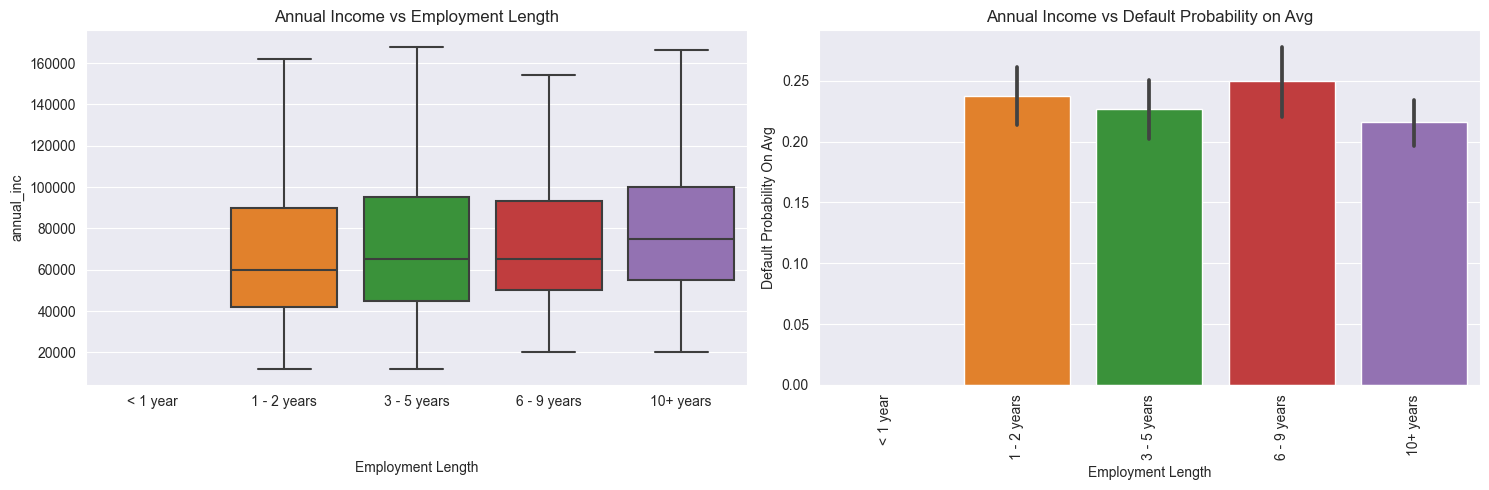

In [155]:
mean_default_prob = loan.groupby("emp_length_cat")["loan_default"].mean().reset_index()
mean_default_prob = mean_default_prob.sort_values(by="loan_default", ascending=False)

# Create subplots
fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, sharey= False)

# Boxplot on the first subplot
sns.boxplot(x='emp_length_cat', y='annual_inc', data=loan, showfliers=False, order= emp_length_unique_list, ax=ax1)
ax1.set_title("Annual Income vs Employment Length")
ax1.set_xlabel("Employment Length", labelpad=38)

# Bar plot on the second subplot
sns.barplot(x='emp_length_cat', y='loan_default', data=loan , order = emp_length_unique_list, ax=ax2)
ax2.set_title("Annual Income vs Default Probability on Avg")
ax2.set_xlabel("Employment Length")
# Set y-label for the bar plot
ax2.set_ylabel("Default Probability On Avg")

# Rotate x-axis labels for better readability
ax2.tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

We can see that there is an increase with employment length and their annual income. However, when taking in the average probability for defaulting, there is no clear relationship with defaulting.

In [156]:
get_ct(loan, 'emp_length')

loan_default,0,1,Defaulted(%)
emp_length,,,
1,932,290,23.73
2,871,255,22.65
3,646,215,24.97
4,1404,387,21.61
All,3853,1147,22.94


- Interesting aspect in this situation is that there is no data for < 1 year of employment length

**Home Ownership (Behavioural Factor)**

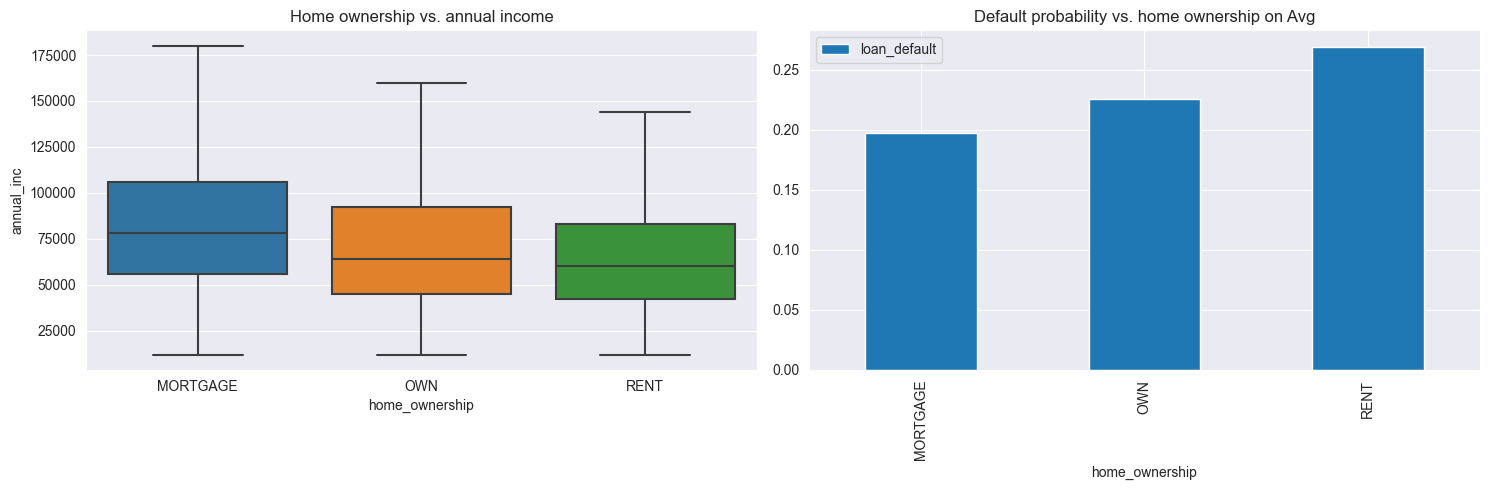

In [157]:
fig, (ax1, ax2) = plt.subplots(figsize = (15,5), ncols=2, sharey= False)
sns.boxplot(x="home_ownership",y="annual_inc", data = loan, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Home ownership vs. annual income")
loan[["home_ownership",'loan_default']].groupby("home_ownership").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership on Avg");

# Adjust layout
plt.tight_layout()

- As suspected, annual income for people who rent tend to be lower than people who own or take a mortgage, and their probabilility of defaulting is the highest.
- This could play as a beneficial factor when determining a behavioural factor for deciding our model.

In [158]:
get_ct(loan, 'home_ownership')

loan_default,0,1,Defaulted(%)
home_ownership,,,
MORTGAGE,1945,479,19.76
OWN,466,136,22.59
RENT,1442,532,26.95
All,3853,1147,22.94


### Bivariate Analysis

#### **Marginal distribution of Default Status based on Log-Annual Income**

Text(0.5, 1.0, 'Annual Income -- Loan Status')

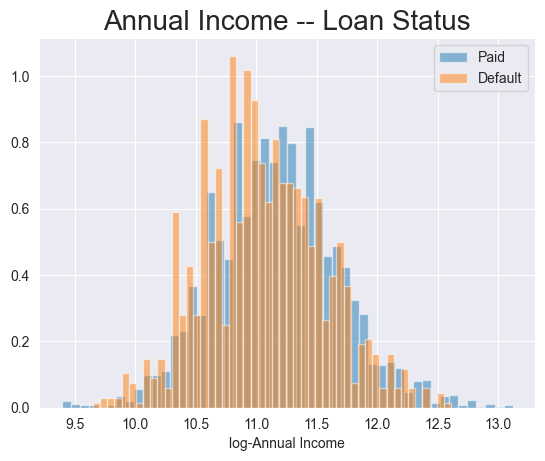

In [159]:
loan['annual_inc_log'][loan.loan_default == 0].hist(bins=50, density=True, alpha=0.5, label="Paid")
loan['annual_inc_log'][loan.loan_default == 1].hist(bins=50, density=True, alpha=0.5, label="Default")
plt.xlabel("log-Annual Income")
plt.legend()
plt.title("Annual Income -- Loan Status", fontsize=20)

- We can see that the distribution for both the groups in terms of their annual income are similarly distributed.
- This can indicate that income is not likely to explain the difference in loan status.

#### **Annual Income & Monthly Installments**

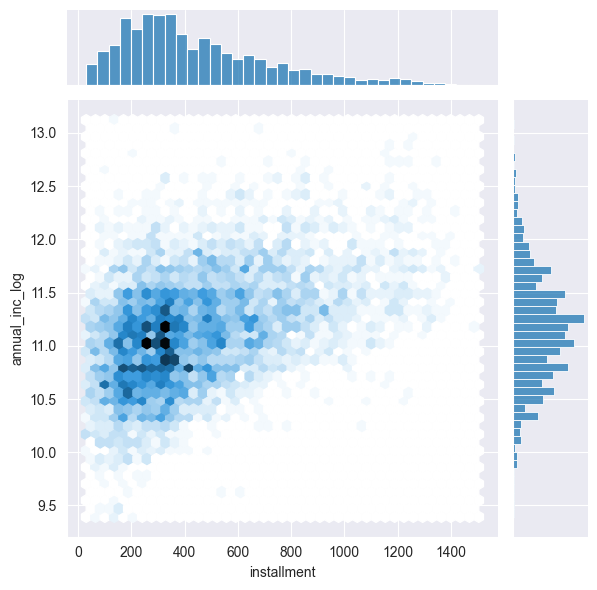

In [160]:
sns.jointplot(data = loan, x = 'installment', y = 'annual_inc_log', kind="hex")

- As mentioned previously, the installment predictor is skewed positively. We will need it to undergo a log transformation

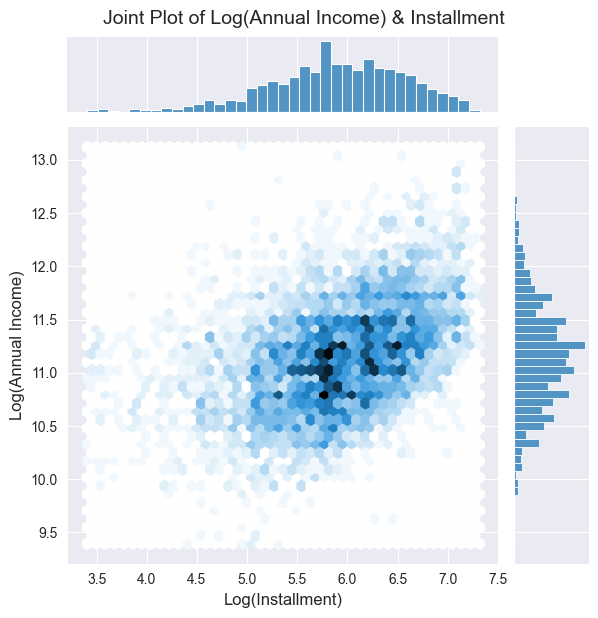

In [161]:
joint_plot = sns.jointplot(data = loan, x = np.log(loan.installment), y = 'annual_inc_log', kind="hex")
joint_plot.fig.suptitle("Joint Plot of Log(Annual Income) & Installment", fontsize=14, y=1.02)
joint_plot.set_axis_labels("Log(Installment)", "Log(Annual Income)", fontsize=12)

- We can see that there is a more linear relationship between these 2 variables, with a few outliers on the far left.

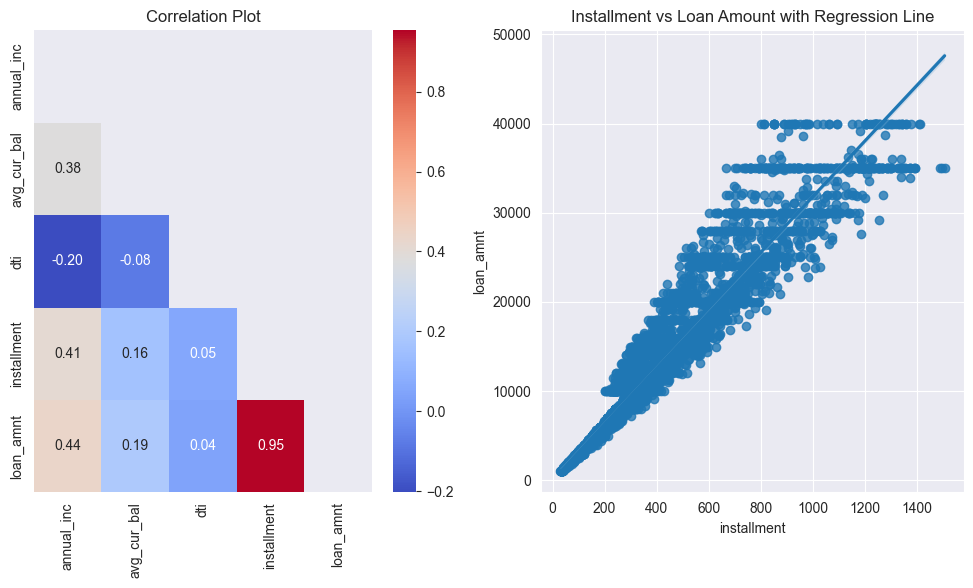

<Figure size 1000x800 with 0 Axes>

In [162]:
# Create a correlation plot to see how each pair of variables relate to one another.
# Compute the correlation matrix.
corr_matrix = loan[feature.select_dtypes(include=['float']).columns].corr()
# Create a mask to hide the upper triangle of our corrplot
mask = np.triu(np.ones_like(corr_matrix))

# Plotting the heatmap for correlation.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask = mask, ax=axes[0])
sns.regplot(x = 'installment', y = 'loan_amnt', data = loan, ax=axes[1])

# Set titles
axes[0].set_title('Correlation Plot')
axes[1].set_title('Installment vs Loan Amount with Regression Line')

axes[1].set_xlabel('installment')
axes[1].set_ylabel('loan_amnt')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


Correlation is huge for "installment" and "loan_amnt", which means the monthly payment owed by the borrower and the listed amount of the loan applied for by the borrower has a strong correlation. This is reasonable given a borrower needs to pay back more per month their debt back if the debt amount is huge.

Since "installment" and "loan amount" are so closely related, we need to check if they have a linear relationship. If colinearity exists, then we should ignore one of them.

For this analysis we will drop the loan_amnt variable as installment will play a major role as a factor in our hypothesis.

In [163]:
loan = loan.drop('loan_amnt', axis = 1)

### Missing Values Treatment

In [164]:
#Missing value treatment
# checking missing values
loan.isnull().sum()

annual_inc                  0
application_type            0
avg_cur_bal                 0
chargeoff_within_12_mths    0
delinq_2yrs                 0
dti                         0
emp_length                  0
grade                       0
inq_last_12m                0
installment                 0
num_actv_bc_tl              0
pub_rec_bankruptcies        0
home_ownership              0
term                        0
mort_acc                    0
num_tl_90g_dpd_24m          0
purpose                     0
loan_default                0
job                         0
emp_length_cat              0
avg_cur_bal_log             0
dti_log                     0
annual_inc_log              0
dtype: int64

There are no missing values in any of our variables.

### Outlier Treatment

In [165]:
def outlier_check(column):
  # Specify the numerical columns for outlier detection
  numerical_columns = loan.select_dtypes(include=['float64']).columns

  # Calculate the IQR for each numerical column
  Q1 = column.quantile(0.25)
  Q3 = column.quantile(0.75)
  IQR = Q3 - Q1

  # Identify outliers
  outliers = ((loan[numerical_columns] < (Q1 - 1.5 * IQR)) | (loan[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
  #return outliers[outliers == True]
  return loan[outliers]

# Generate a list of numerical columns
numerical_columns = loan.select_dtypes(include=['float64']).columns

# Calculate an array of IQR for each numerical column
Q1 = loan[numerical_columns].quantile(0.25)
Q3 = loan[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((loan[numerical_columns] < (Q1 - 1.5 * IQR)) | (loan[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Display the outliers
loan[outliers][numerical_columns]

,annual_inc,avg_cur_bal,dti,installment,avg_cur_bal_log,dti_log,annual_inc_log
12,75000.0,742.0,1.22,542.07,6.610696,0.797507,11.225243
34,79000.0,4088.0,22.14,1327.45,8.316056,3.141563,11.277203
35,52000.0,51655.0,15.94,184.35,10.852362,2.829678,10.858999
38,185000.0,21735.0,4.09,402.08,9.986725,1.627278,12.128111
39,400000.0,64556.0,10.07,1174.91,11.075304,2.404239,12.899220
...,...,...,...,...,...,...,...
4948,96000.0,91931.0,8.24,285.71,11.428804,2.223542,11.472103
4950,173000.0,20760.0,28.22,287.44,9.940832,3.374853,12.061047
4959,15000.0,1960.0,34.86,171.11,7.581210,3.579622,9.615805
4962,85000.0,44945.0,13.53,125.30,10.713217,2.676215,11.350407


- As we can see there are about 621 data points that contain outlier data.
- For now we will leave the data how it is, and in the future decide what best to do with these outliers.

### Variable Transformation/Creation

#### **Yearly Installment Income**

- The yearly payment owed by the borrower, as a fraction of annual income, is a standard metric used in evaluating whether a loan should be issued.
- We create a new variable that calculates this using the installment variable and annual income

Text(0.5, 0, 'Installment / Income')

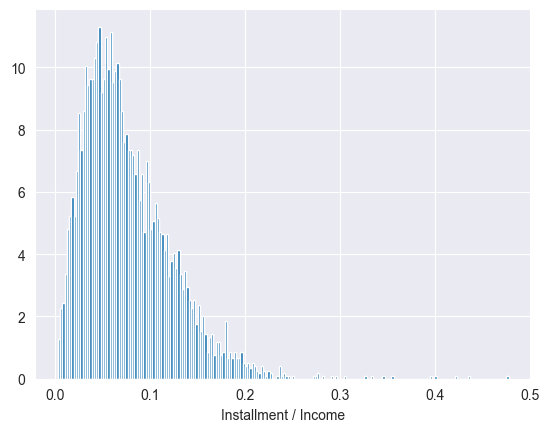

In [166]:
loan['install_income'] = 12 * loan.installment / loan.annual_inc
H = plt.hist(loan['install_income'], bins=200, density=True)
plt.xlabel(r"Installment / Income")

- Quite clearly, we see the distribution is positively skewed, it will need a transformation when we would like to test for significance.

Text(0, 0.5, 'Loan Default Percentage')

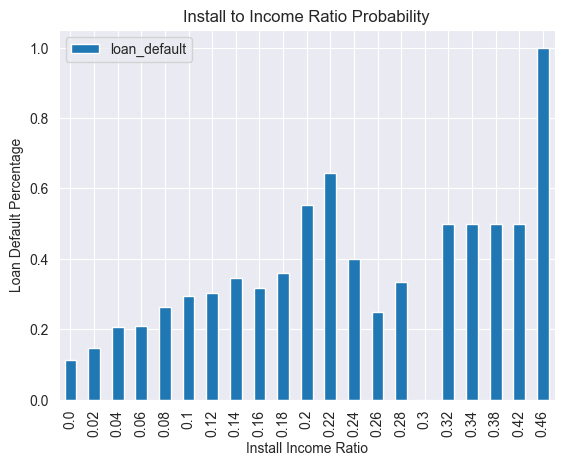

In [167]:
# let us discretize the "install_income" variable to study the probability of default
# as a function of "install_income"
loan["install_income_disc"] = (loan.install_income*50).astype(int)/50.  #discretization
loan[["loan_default", "install_income_disc"]].groupby("install_income_disc").mean().plot.bar(rot=90)
loan = loan.drop(["install_income_disc"], axis=1)
plt.title("Install to Income Ratio Probability")
plt.xlabel("Install Income Ratio")
plt.ylabel("Loan Default Percentage")

- There is a clear positive association: as the fraction of the annual income devoted to the re-imbursement of the loan increases, the probability of default sharply increases

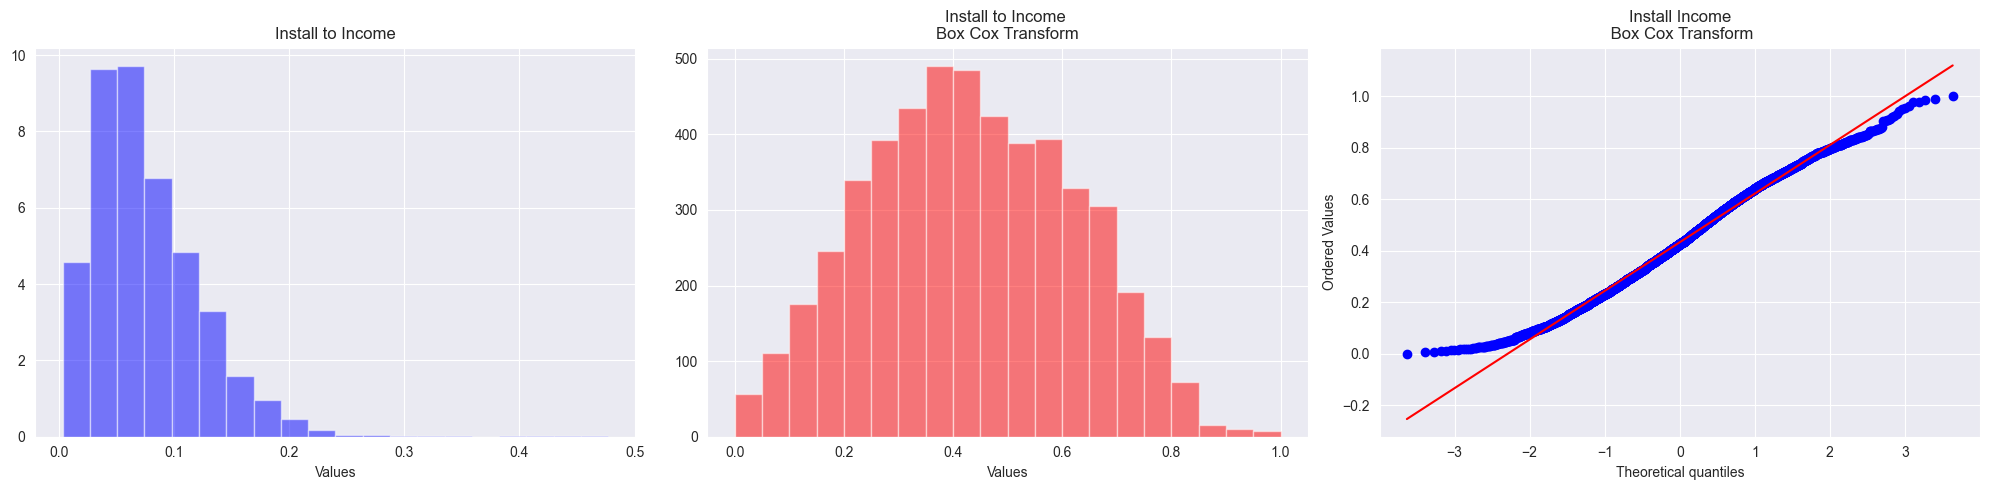

In [168]:
# Here we are going to transform our new variable using the box cox method in order for it to be normally distributed. Reason for using box cox method was to avoid using log transformation due to the values being between 0 and 0.5 due to it being a ratio.
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
transformed_data, _ = boxcox(loan['install_income'] + 1)
# Scale the transformed data to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
transformed_data_scaled = scaler.fit_transform(transformed_data.reshape(-1, 1)).flatten()

# Plot histograms of original and transformed data
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.hist(loan.install_income, bins=20, color='blue', alpha=0.5, density= True)
plt.title('Install to Income')
plt.xlabel('Values')

plt.subplot(1, 3, 2)
plt.hist(transformed_data_scaled, bins=20, color='red', alpha=0.5)
plt.title('Install to Income \nBox Cox Transform')
plt.xlabel('Values')

plt.subplot(1, 3, 3)
stats.probplot(transformed_data_scaled, dist="norm", plot= plt)
plt.title("Install Income\n Box Cox Transform")

# Adjust layout
plt.tight_layout()

plt.show()

# Adding this variable to our loan data
loan['install_income_norm'] = transformed_data_scaled

We want to assess whether there is a signficance of the install_income with respect to loan_default parameter using the t test.

$ \mu_1$ is the mean of install income given that they have not defaulted
$ \mu_2$ is the mean of install income given that they have defaulted
$$ H_0: \mu_1=\mu_2$$
$$H_a: \mu_1 \neq \mu_2$$

In [169]:
from scipy.stats import ttest_ind
binary_categorical_variable = loan['loan_default']
transformed_data = loan['install_income_norm']

# Perform t-test for independent samples
t_statistic, p_value = ttest_ind(transformed_data[binary_categorical_variable == 0],
                                  transformed_data[binary_categorical_variable == 1])

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -12.482459955482879
P-value: 3.105367751892538e-35


Based on the statistical test above, we can **reject the null hypothesis**. We can definitely see there is huge difference in means resulting in high correlation between them.

#### Categorical Variables Dummy Creation & Ordinal Variable (employment length)

Nominal Categorical Variable:
- application_type
- home_ownership
    - Behavioural factor
- purpose
- job
    - Behavioural factor

Ordinal Categorical Variable:
- employment length
    - Behavioural factor


We will only focus on the variables that have a behavioural factor, as this is our experimental goal in our analysis.

We might have issues when looking at job as a categorical variable due to how many unique items there are.

Approaches:
Reduce dimensionality to major sectors of jobs.


##### Job (Behavioral Factor)

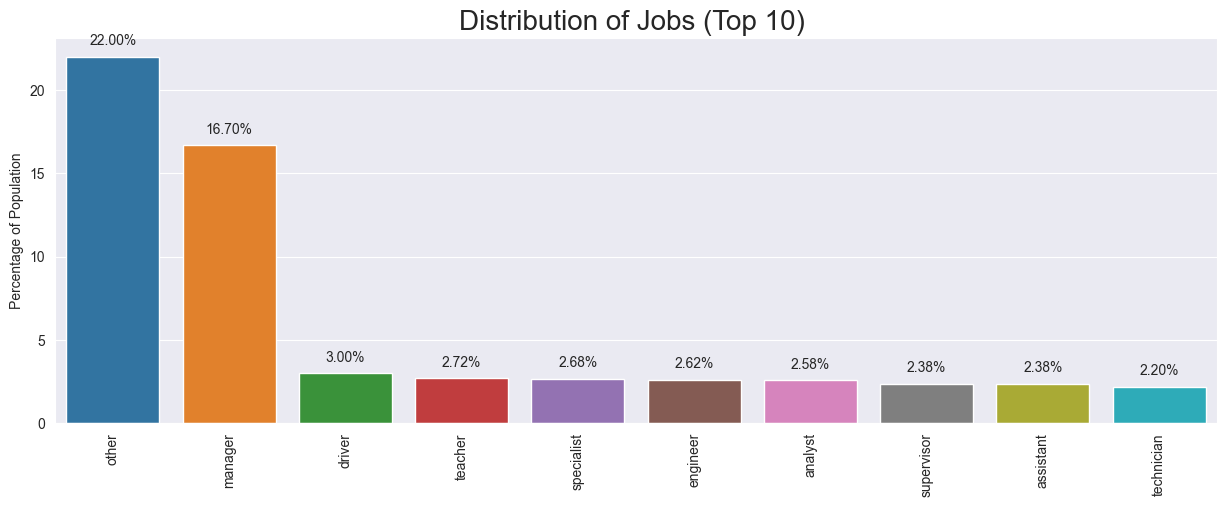

In [170]:
plt.figure(figsize= (15,5))
ax = sns.barplot(x=list(loan["job"].value_counts()[:10].index.values),
            y=100 * loan.job.value_counts()[:10].values / len(loan),
            orient="v",
            )

counts = loan['job'].value_counts()[:10]
total_obs = len(loan['job'])
percentage = (counts / total_obs) * 100
percentages_sorted = percentage.sort_values(ascending=False)

for i, percentage in enumerate(percentages_sorted):
    ax.text(i, percentage + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Jobs (Top 10) ", fontsize=20);

In [171]:
print("Distinct Jobs in Dataset: ", loan['job'].nunique())

Distinct Jobs in Dataset:  119


Since we have 119 various distinct jobs in our dataset, we can consider consolidating them into major industry sectors:
1. Science_Tech
2. Healthcare
3. Finance & Banking
4. Education
5. Manufacturing
6. Retail
7. Hospitality & Tourism
8. Construction
9. Transportation
10. Law
11. Administration
12. Maintenance
13. Public Safety
14. Business Executives
15. Other

In [172]:
Science_Tech = ['it', 'programmer', 'support', 'tech', 'technologist', 'engineer', 'scientist']
HealthCare = ['examiner', 'hygienist', 'nurse', 'paramedic', 'pharmacist', 'physician', 'practitioner', 'therapist', 'trainer']
Finance_Banking = ['accountant', 'accounting', 'adjuster', 'auditor', 'banker', 'bookkeeper', 'finance', 'sales', 'teller', 'underwriter']
Education = ['educator', 'instructor','professor', 'teacher', 'principal']
Manufacturing = ['operations', 'warehouse', 'welder']
Retail = ['cashier']
Hospitality_Tourism = ['bartender', 'chef', 'cook', 'server', 'service', 'services']
Construction = ['architect', 'carpenter', 'controller', 'developer', 'foreman', 'laborer', 'machinist']
Transportation = ['carrier', 'driver']
Law = ['attorney', 'consultant', 'paralegal']
Administration = ['administration', 'admin', 'clerk', 'management', 'manager', 'manger', 'receptionist', 'recruiter', 'resources', 'secretary', 'supervisor', 'assistant']
Maintenance = ['custodian', 'electrician', 'installer', 'maintenance', 'painter', 'technician']
Public_Safety = ['firefighter', 'investigator', 'officer', 'security', 'sergeant', 'superintendent', 'chief','dispatcher' ]
Business_Management = ['partner', 'ceo', 'director', 'executive', 'president', 'vp']
Other = ['advisor', 'agent', 'aide', 'analyst', 'associate', 'attendant','broker','buyer','captain', 'coach', 'coordinator', 'counselor', 'dealer','designer','estimator', 'handler', 'inspector', 'lead','leader', 'marketing', 'operator', 'other', 'owner', 'pastor', 'planner', 'realtor', 'representative','specialist', 'worker' ]

sector_job_mapping = {'sci_tech': Science_Tech,
              'finance_bank': Finance_Banking,
              'education': Education,
              'manufacture': Manufacturing,
              'retail': Retail,
              'hospitalitty_tourism': Hospitality_Tourism,
              'construction': Construction,
              'transport': Transportation,
              'law': Law,
              'admin': Administration,
              'maintenance': Maintenance,
              'public_safety': Public_Safety,
              'business_execs': Business_Management,
              'other': Other}

def map_job_to_sector(job):
    for sector, jobs in sector_job_mapping.items():
        if job in jobs:
            return sector
    return 'other'  # Assign 'Other' if job does not match any sector

loan['job_sector'] = loan['job'].apply(map_job_to_sector)

print("Distinct Jobs in Dataset: ", loan['job_sector'].nunique())

Distinct Jobs in Dataset:  14


As we can see with the above output, we have now reduced it by major sectors to 15.

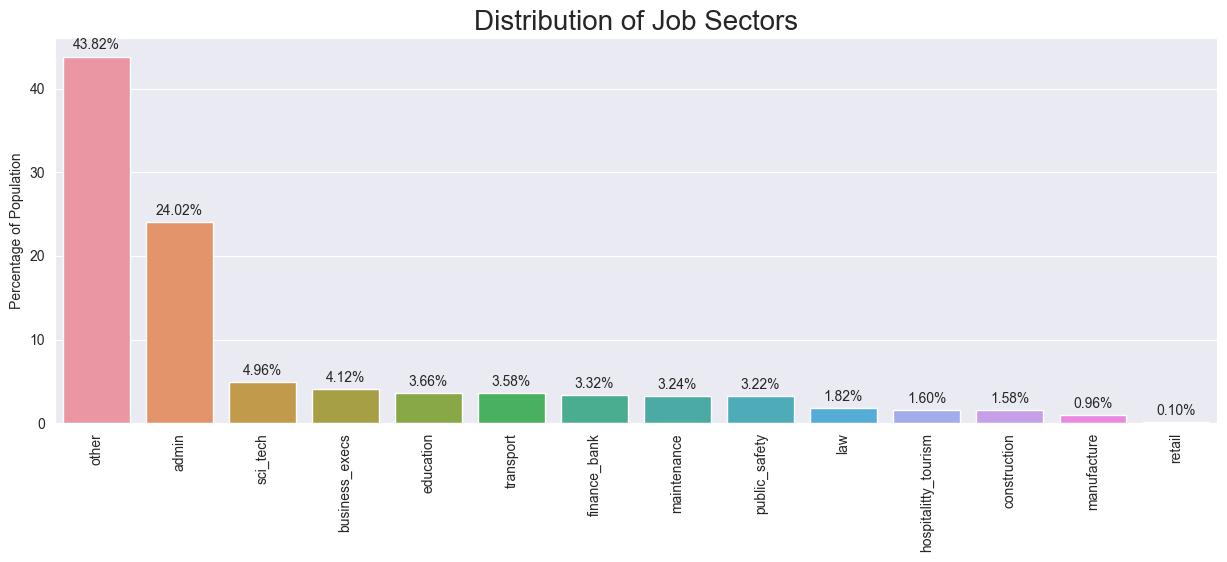

In [173]:
plt.figure(figsize= (15,5))
ax = sns.barplot(x=list(loan["job_sector"].value_counts()[:15].index.values),
                 y=100 * loan.job_sector.value_counts()[:15].values / len(loan),
                 orient="v",
                 )

counts = loan['job_sector'].value_counts()[:15]
total_obs = len(loan['job_sector'])
percentage = (counts / total_obs) * 100
percentages_sorted = percentage.sort_values(ascending=False)

for i, percentage in enumerate(percentages_sorted):
    ax.text(i, percentage + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Job Sectors", fontsize=20);

In [174]:
# Create and Update to categorical data
cat_job              = pd.get_dummies(loan['job_sector'], prefix= 'jobSector', drop_first= True)
cat_purpose          = pd.get_dummies(loan['purpose'], prefix= 'purpose', drop_first= True)
cat_application_type = pd.get_dummies(loan['application_type'], prefix= 'app_type', drop_first= True)
cat_home_ownership   = pd.get_dummies(loan['home_ownership'], prefix= 'home_own', drop_first= True)
loan = pd.concat([loan, cat_purpose], axis= 1)
loan = pd.concat([loan, cat_application_type], axis= 1)
loan = pd.concat([loan, cat_home_ownership], axis= 1)
loan = pd.concat([loan, cat_job], axis = 1)

# Remove unnecessary variables, that will not be used for the model
loan2 = loan.drop(['purpose',
                   'application_type',
                   'home_ownership',
                   'emp_length_cat',
                   'annual_inc',
                   'annual_inc_log',
                   'installment',
                   'install_income',
                   'avg_cur_bal',
                   'dti',
                   'job',
                   'job_sector'], axis = 1)

In [175]:
loan2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   chargeoff_within_12_mths        5000 non-null   int64  
 1   delinq_2yrs                     5000 non-null   int64  
 2   emp_length                      5000 non-null   int64  
 3   grade                           5000 non-null   int64  
 4   inq_last_12m                    5000 non-null   int64  
 5   num_actv_bc_tl                  5000 non-null   int64  
 6   pub_rec_bankruptcies            5000 non-null   int64  
 7   term                            5000 non-null   int64  
 8   mort_acc                        5000 non-null   int64  
 9   num_tl_90g_dpd_24m              5000 non-null   int64  
 10  loan_default                    5000 non-null   int64  
 11  avg_cur_bal_log                 5000 non-null   float64
 12  dti_log                         50

In [176]:
loan2.head()

,chargeoff_within_12_mths,delinq_2yrs,emp_length,grade,inq_last_12m,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,...,jobSector_finance_bank,jobSector_hospitalitty_tourism,jobSector_law,jobSector_maintenance,jobSector_manufacture,jobSector_other,jobSector_public_safety,jobSector_retail,jobSector_sci_tech,jobSector_transport
0,0,0,4,6,1,1,0,36,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,3,4,0,3,0,60,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,4,6,4,0,60,3,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,3,4,7,2,0,36,4,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,4,4,0,4,0,36,0,0,...,0,0,0,0,0,0,0,0,0,1


## Imbalanced Data Handling

Here we will look at 3 different methods of resampling which are SMOTE, ADAYSN and SMOTE ENN. To test out each of how well each re-sampling is conducted, we will use a Logistic Regression on the full model and use recall and f1 score as our scoring point.

In [177]:
df = loan2.copy()
print('Loan Default class percentages:')
class_percentage = df['loan_default'].value_counts(normalize=True) * 100
print(class_percentage)
print(df.loan_default.value_counts())

Loan Default class percentages:
0    77.06
1    22.94
Name: loan_default, dtype: float64
0    3853
1    1147
Name: loan_default, dtype: int64


In [178]:
X = df.drop(columns='loan_default', axis = 1)
Y = df['loan_default'].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state= 1)

print("Training Dimensions:")
print("X = ", X_train.shape, "Y = ", Y_train.shape)
print("Testing Dimensions:")
print("X = ", X_test.shape, "Y = ", Y_test.shape)

Training Dimensions:
X =  (3750, 40) Y =  (3750,)
Testing Dimensions:
X =  (1250, 40) Y =  (1250,)


In [179]:
# Building a logistic model to test the up-sampling
def logModel_testing(X_train, Y_train, X_test, Y_test):
    from sklearn.linear_model import LogisticRegression
    logistic_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear').fit(X_train,Y_train)
    y_pred = logistic_model.predict(X_test)

    # Classification Metrics
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)

    print("Recall and F1 Scoring Metrics: ")
    print("recall : ", round(recall*100, 4), "%")
    print("F1     : ", round(f1*100, 4), "%")
    target_names = ['class 0', 'class 1']
    print("-----------------------------------------------------------------")
    print("Classification Report ")
    print(classification_report(Y_test, y_pred, target_names=target_names))
    print("-----------------------------------------------------------------")

    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_pred,Y_test))

    # Visual Plot of Confusion Matrix
    # from sklearn.metrics import ConfusionMatrixDisplay
    # dis = ConfusionMatrixDisplay(confusion_matrix= cf_matrix )
    # dis.plot(cmap=plt.cm.Blues)
    # plt.show()

#### Without Any Resampling

In [180]:
logModel_testing(X_train, Y_train, X_test, Y_test)

Recall and F1 Scoring Metrics: 
recall :  9.772 %
F1     :  16.2602 %
-----------------------------------------------------------------
Classification Report 
              precision    recall  f1-score   support

     class 0       0.77      0.97      0.85       943
     class 1       0.48      0.10      0.16       307

    accuracy                           0.75      1250
   macro avg       0.63      0.53      0.51      1250
weighted avg       0.70      0.75      0.68      1250

-----------------------------------------------------------------
Confusion Matrix:
[[911 277]
 [ 32  30]]


In [181]:
df_train = pd.concat([X_train, Y_train], axis = 1)
df_majority = df_train[df_train['loan_default']==0]
df_minority = df_train[df_train['loan_default']==1]

### Method 1: SMOTE with Undersampling

Synthetic Minority Over-Sampling technique is a pre-processing technique used to address a class imbalance in a datatset. The SMOTE algorithm is as follows:
- Take difference between a sample and its nearest neighbour
- Multiply the difference by a random number between 0 and 1
- Add this difference to the sample to generate a new synthetic example in feature space
- Continue on with next nearest neighbour up to user-definied number.

The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class.

In [182]:
X_train_smote = df_train.drop('loan_default', axis=1)
Y_train_smote = df_train['loan_default']

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy = 0.9)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_train_res, Y_train_res = pipeline.fit_resample(X_train_smote, Y_train_smote)

print(X_train_res.shape, Y_train_res.shape)
print("loan_default is 0:", len(Y_train_res[Y_train_res==0]), "\nloan_default is 1:", len(Y_train_res[Y_train_res==1]))

df_train_smote = pd.concat([pd.DataFrame(X_train_res), pd.DataFrame(Y_train_res)], axis= 1)


(2457, 40) (2457,)
loan_default is 0: 1293 
loan_default is 1: 1164


In [183]:
logModel_testing(X_train_res, Y_train_res, X_test, Y_test)

Recall and F1 Scoring Metrics: 
recall :  53.0945 %
F1     :  45.6583 %
-----------------------------------------------------------------
Classification Report 
              precision    recall  f1-score   support

     class 0       0.83      0.74      0.78       943
     class 1       0.40      0.53      0.46       307

    accuracy                           0.69      1250
   macro avg       0.61      0.64      0.62      1250
weighted avg       0.72      0.69      0.70      1250

-----------------------------------------------------------------
Confusion Matrix:
[[699 144]
 [244 163]]


### Method 2: ADASYN

This method is similar to SMOTE but it generates different number of sampling depending on an estimate of the local distribution of the class to be oversampled.



In [184]:
X_train_adasyn = df_train.drop('loan_default', axis=1)
Y_train_adasyn = df_train['loan_default']

from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=3)
X_train_res, Y_train_res = adasyn.fit_resample(X_train_adasyn, Y_train_adasyn.ravel())

print(X_train_res.shape, Y_train_res.shape)
print("loan_default is 0:", len(Y_train_res[Y_train_res==0]), "\nloan_default is 1:", len(Y_train_res[Y_train_res==1]))

df_train_adasyn = pd.concat([pd.DataFrame(X_train_res), pd.DataFrame(Y_train_res)], axis= 1)

(5779, 40) (5779,)
loan_default is 0: 2910 
loan_default is 1: 2869


In [185]:
logModel_testing(X_train_res, Y_train_res, X_test, Y_test)

Recall and F1 Scoring Metrics: 
recall :  38.1107 %
F1     :  38.1107 %
-----------------------------------------------------------------
Classification Report 
              precision    recall  f1-score   support

     class 0       0.80      0.80      0.80       943
     class 1       0.38      0.38      0.38       307

    accuracy                           0.70      1250
   macro avg       0.59      0.59      0.59      1250
weighted avg       0.70      0.70      0.70      1250

-----------------------------------------------------------------
Confusion Matrix:
[[753 190]
 [190 117]]


### Method 3: SMOTE & ENN

This is a combination of 2 methods SMOTE and Edited Nearest Neighbor (ENN) which stems from K-Nearest Neighbor (KNN).

ENN:
ENN works by finding the K-nearest neighbor of each observation first, then check whether the majority class from the observation's k-nearest neighbor is the same as the obervation's class or not. If the majority clss of the observation's K-nearest neighbor and the observation's class is different, then the observation and its K-nearest neighbor are deleted from the dataset.

In default, the number of nearest-neighbor used is ENN is K = 3.

    Algorithm:
    1. Given the dataset with N oberservations, determine K, as the number of nearest neighbors. If not determined, then K=3.
    2. Find the K-nearest neighbor of the observation among the other obs. in the dataset, then return the majority class from the K-nearest neighbor.
    3. If the class of the observation and the majority class from the obs.'s K-nearest neighbor is different, then the observation and its K-nearest neighbor are deleted from the dataset.
    4. Repeat setp 2 and 3 until the desired proportion of each class is fullfilled.

SMOTE-ENN Method:
This method combines the SMOTE ability to generate synthetic examples for minority class and ENN ability to delete some observations from both classes that are identified as having different class betweeen the observation's class and it's K-nearest neighbor majority class. The process of SMOTE-ENN can be explained as follows.

    Algorithm:
    1. (Start of SMOTE) Choose random data from the minority class.
    2. Calculate the distance between the random data and its k nearest neighbor.
    3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
    4. Repeat step number 2-3 until the desired proportion of minority class is met. (End of SMOTE)
    5. (Start of ENN) Determine K, as the number of nearest neighbors. If not determined, then K=3.
    6. Find the K-nearest neighbor of the observation among the other observations in the dataset, then return the majority class from the K-nearest neighbor.
    7. If the class of the observation and the majority class from the observation's K-nearest neighbor is different, then the observation and its K-nearestest neighbor are deleted from the dataset.
    8. Repear step 2 and 3 until the desired proporiton of each class is fullfilled (End of ENN).


In [186]:
X_train_se = df_train.drop('loan_default', axis=1)
Y_train_se = df_train['loan_default']

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
smoteenn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),random_state=3)
X_train_res, Y_train_res = adasyn.fit_resample(X_train_se, Y_train_se.ravel())

print(X_train_res.shape, Y_train_res.shape)
print("loan_default is 0:", len(Y_train_res[Y_train_res==0]), "\nloan_default is 1:", len(Y_train_res[Y_train_res==1]))

df_train_se = pd.concat([pd.DataFrame(X_train_res), pd.DataFrame(Y_train_res)], axis= 1)

(5779, 40) (5779,)
loan_default is 0: 2910 
loan_default is 1: 2869


In [187]:
logModel_testing(X_train_res, Y_train_res, X_test, Y_test)

Recall and F1 Scoring Metrics: 
recall :  38.1107 %
F1     :  38.1107 %
-----------------------------------------------------------------
Classification Report 
              precision    recall  f1-score   support

     class 0       0.80      0.80      0.80       943
     class 1       0.38      0.38      0.38       307

    accuracy                           0.70      1250
   macro avg       0.59      0.59      0.59      1250
weighted avg       0.70      0.70      0.70      1250

-----------------------------------------------------------------
Confusion Matrix:
[[753 190]
 [190 117]]


We get similar results to our ADASYN re-sampling technique

#### RESULTS FROM THE RESAMPLING:

| Resampling Technique | Overall Model     |
|                      | Recall | F1 Score |
|----------------------|--------|----------|
| No Re-Sampling       | 9.77%  |  16.26%  |
| SMOTE w DownSample   | 55.37% |  47.42%  |
| ADASYN               | 38.11% |  38.11%  |
| SMOTE & ENN          | 38.11% |  38.11%  |

Based on the above table and looking at specifically recall and F1 we can see that with the re-sampling we achieve much better results. I would recommend using up SMOTE with downsampling for performing the rest of the analysis in the model building.

## Model Building

Recall that our task is to build a model with quantitative and behavioural factors. So far we have seen that install/income is a key quantitative element in classifying loan default. However, we now need to add behavioural factors such as Home Ownership, Employment Length and Job to see how well our model will run as compared to running all the given features available.

For our model building and model selection we will be using 3 different classification models.
- Logisitic Regression
- Decision Tree
- SVM with a linear kernel
- K Nearest Neighbours

We will perform a 10-fold for our cross validation to be understand how well each model does.


For each model building we will be testing various combinations of predictors rather than a full model to come up with the best model we feel can work with this data. Each of the models will contain Install/Income as we showed that it has significant association with loan default.

**Model 0:** All Features
**Model 1:** Install/Income
**Model 2:** Install/Income + Home Ownership
**Model 3:** Install/Income + Employment Length
**Model 4:** Install/Income + Job (By Sector)
**Model 5:** Install/Income + Home Ownership + Employment Length
**Model 6:** Install/Income + Home Ownership + Job (By Sector)
**Model 7:** Install/Income + Job (By Sector) + Employment Length
**Model 8:** Install/Income + Home Ownership + Employment Length + Job (By Sector)

### Cross Validation Function

Here we define how we conduct our cross validation, using resampling technique. For our measuring technique, we will once again use F1 score.

In [199]:
df_modelling = loan2.copy()
def model_score(X, Y):
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.tree import DecisionTreeClassifier
    from numpy import mean
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from imblearn.pipeline import Pipeline
    from imblearn.over_sampling import SMOTE

    # Classifier Models
    log    = LogisticRegression(solver='lbfgs',
                                tol=10**-4,
                                fit_intercept=True,
                                max_iter= 1000
                                )
    tree   = DecisionTreeClassifier(criterion='entropy')
    svm    = SVC(C = 1)
    knn    = KNeighborsClassifier(metric= 'euclidean')
    models = [log, tree, svm, knn]
    names  = ["Logistic Regression", "Decision Tree Classifier",
              "SVM", "K Nearest Neighbor"
              ]
    for model, name in zip(models, names):
        # Pipeline
        over     = SMOTE(sampling_strategy=0.4)
        under    = RandomUnderSampler(sampling_strategy = 0.9)
        steps    = [('over', over), ('under', under), ('model', model)]
        pipeline = Pipeline(steps=steps)
        # Evaluate Pipeline
        cv            = RepeatedStratifiedKFold(n_splits= 10,
                                            n_repeats= 3,
                                            random_state= 1
                                            )
        scores_f1     = cross_val_score(pipeline, X, Y,
                                 scoring= "f1",
                                 cv = cv,
                                 n_jobs = 1)
        scores_recall = cross_val_score(pipeline, X, Y,
                                    scoring= "recall",
                                    cv = cv,
                                    n_jobs = 1)

        mean_f1     = (mean(scores_f1)*100)
        mean_recall = (mean(scores_recall)*100)
        print("Using Sampling Technique On Training Data")
        print("Mean F1     % for {}: {:.2f} %".format(name, mean_f1))
        print("Mean Recall % for {}: {:.2f} %".format(name, mean_recall))
        print('-----------------------------------------------------')
        print('Without Using Sampling Technique on Training')
        scores_f1     = cross_val_score(model, X, Y,
                                        scoring= "f1",
                                        cv = cv,
                                        n_jobs = 1)
        scores_recall = cross_val_score(model, X, Y,
                                    scoring= "recall",
                                    cv = cv,
                                    n_jobs = 1)
        mean_f1     = (mean(scores_f1)*100)
        mean_recall = (mean(scores_recall)*100)
        print("Mean F1     % for {}: {:.2f} %".format(name, mean_f1))
        print("Mean Recall % for {}: {:.2f} %".format(name, mean_recall))
        print('-----------------------------------------------------')
        print('-----------------------------------------------------')

### Models

In [200]:
Y = df_modelling['loan_default'].copy()

#### Model 0: X = all features

In [201]:
X = df_modelling.drop(columns= 'loan_default', axis = 1)
print("Model 0: Full Model:")
model_score(X, Y)

Model 0: Full Model:
Using Sampling Technique On Training Data
Mean F1     % for Logistic Regression: 42.81 %
Mean Recall % for Logistic Regression: 51.99 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Logistic Regression: 20.98 %
Mean Recall % for Logistic Regression: 13.17 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for Decision Tree Classifier: 35.73 %
Mean Recall % for Decision Tree Classifier: 50.28 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Decision Tree Classifier: 30.92 %
Mean Recall % for Decision Tree Classifier: 32.12 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for SVM: 39.63 %
Mean Recall 

#### Model 1: X = Install/Income

In [202]:
from sklearn.preprocessing import StandardScaler
X = df_modelling[['install_income_norm']]
print("Model 1: Install/Income:")
model_score(X, Y)

Model 1: Install/Income:
Using Sampling Technique On Training Data
Mean F1     % for Logistic Regression: 37.55 %
Mean Recall % for Logistic Regression: 48.88 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Logistic Regression: 0.00 %
Mean Recall % for Logistic Regression: 0.00 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for Decision Tree Classifier: 32.09 %
Mean Recall % for Decision Tree Classifier: 46.33 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Decision Tree Classifier: 25.08 %
Mean Recall % for Decision Tree Classifier: 25.11 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for SVM: 37.16 %
Mean Recal

#### Model 2: X = Install/Income + Home Ownership

In [203]:
X_cols = [col for col in df_modelling.columns if col.startswith('home') or col.startswith('install_income')]
X = df_modelling[X_cols]
print("Model 2: Install/Income + Homeownship:")
model_score(X, Y)

Model 2: Install/Income + Homeownship:
Using Sampling Technique On Training Data
Mean F1     % for Logistic Regression: 38.27 %
Mean Recall % for Logistic Regression: 49.75 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Logistic Regression: 0.52 %
Mean Recall % for Logistic Regression: 0.26 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for Decision Tree Classifier: 33.36 %
Mean Recall % for Decision Tree Classifier: 48.06 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Decision Tree Classifier: 25.89 %
Mean Recall % for Decision Tree Classifier: 25.98 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for SVM: 37.6

#### Model 3: Install/Income + Employment Length

In [204]:
X = df_modelling[['install_income_norm', 'emp_length']]
print("Model 3: Install/Income + Employment Length:")
model_score(X, Y)

Model 3: Install/Income + Employment Length:
Using Sampling Technique On Training Data
Mean F1     % for Logistic Regression: 37.42 %
Mean Recall % for Logistic Regression: 48.50 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Logistic Regression: 0.11 %
Mean Recall % for Logistic Regression: 0.06 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for Decision Tree Classifier: 32.40 %
Mean Recall % for Decision Tree Classifier: 47.72 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Decision Tree Classifier: 26.36 %
Mean Recall % for Decision Tree Classifier: 26.77 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for SVM

#### Model 4: Install/Income + Job (By Sector)

In [205]:
X_cols = [col for col in df_modelling.columns if col.startswith('job') or col.startswith('install_income')]
X = df_modelling[X_cols]
print("Model 4: Install/Income + Job (By Sector):")
model_score(X, Y)

Model 4: Install/Income + Job (By Sector):
Using Sampling Technique On Training Data
Mean F1     % for Logistic Regression: 37.01 %
Mean Recall % for Logistic Regression: 47.69 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Logistic Regression: 0.74 %
Mean Recall % for Logistic Regression: 0.38 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for Decision Tree Classifier: 32.79 %
Mean Recall % for Decision Tree Classifier: 46.64 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Decision Tree Classifier: 25.79 %
Mean Recall % for Decision Tree Classifier: 26.13 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for SVM: 

#### Model 5: Install/Income + Home Ownership + Employment Length

In [206]:
X_cols = [col for col in df_modelling.columns if col.startswith('install_income') or col.startswith('home') or col.startswith('emp')]
X = df_modelling[X_cols]
print("Model 5: Install/Income + Home Ownership + Employment Length")
model_score(X, Y)

Model 5: Install/Income + Home Ownership + Employment Length
Using Sampling Technique On Training Data
Mean F1     % for Logistic Regression: 38.09 %
Mean Recall % for Logistic Regression: 50.36 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Logistic Regression: 0.52 %
Mean Recall % for Logistic Regression: 0.26 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for Decision Tree Classifier: 33.02 %
Mean Recall % for Decision Tree Classifier: 48.39 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Decision Tree Classifier: 26.80 %
Mean Recall % for Decision Tree Classifier: 27.12 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean 

#### Model 6: Install/Income + Home Ownership + Job (By Sector)

In [207]:
X_cols = [col for col in df_modelling.columns if col.startswith('install_income') or col.startswith('home') or col.startswith('jobSector')]
X = df_modelling[X_cols]
print("Model 6: Install/Income + Home Ownership + Job (By Sector)")
model_score(X, Y)

Model 6: Install/Income + Home Ownership + Job (By Sector)
Using Sampling Technique On Training Data
Mean F1     % for Logistic Regression: 38.09 %
Mean Recall % for Logistic Regression: 49.96 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Logistic Regression: 1.20 %
Mean Recall % for Logistic Regression: 0.61 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for Decision Tree Classifier: 32.47 %
Mean Recall % for Decision Tree Classifier: 49.12 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Decision Tree Classifier: 27.16 %
Mean Recall % for Decision Tree Classifier: 27.70 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1

#### Model 7: Install/Income + Employment Length + Job (By Sector)

In [208]:
X_cols = [col for col in df_modelling.columns if col.startswith('install_income') or col.startswith('emp') or col.startswith('jobSector')]
X = df_modelling[X_cols]
print("Model 7: Install/Income + Employment Length + Job (By Sector)")
model_score(X, Y)

Model 7: Install/Income + Employment Length + Job (By Sector)
Using Sampling Technique On Training Data
Mean F1     % for Logistic Regression: 37.06 %
Mean Recall % for Logistic Regression: 48.15 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Logistic Regression: 0.80 %
Mean Recall % for Logistic Regression: 0.41 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for Decision Tree Classifier: 32.53 %
Mean Recall % for Decision Tree Classifier: 47.78 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Decision Tree Classifier: 26.69 %
Mean Recall % for Decision Tree Classifier: 27.29 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean

#### Model 8: Install/Income + Home Ownership + Employment Length + Job (By Sector)

In [209]:
X_cols = [col for col in df_modelling.columns if col.startswith('install_income') or col.startswith('home') or col.startswith('emp') or col.startswith('jobSector')]
X = df_modelling[X_cols]
print("Model 8: Install/Income + Home Ownership + Employment Length + Job (By Sector)")
model_score(X, Y)

Model 8: Install/Income + Home Ownership + Employment Length + Job (By Sector)
Using Sampling Technique On Training Data
Mean F1     % for Logistic Regression: 38.12 %
Mean Recall % for Logistic Regression: 49.66 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Logistic Regression: 1.20 %
Mean Recall % for Logistic Regression: 0.61 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On Training Data
Mean F1     % for Decision Tree Classifier: 33.90 %
Mean Recall % for Decision Tree Classifier: 48.71 %
-----------------------------------------------------
Without Using Sampling Technique on Training
Mean F1     % for Decision Tree Classifier: 27.57 %
Mean Recall % for Decision Tree Classifier: 27.70 %
-----------------------------------------------------
-----------------------------------------------------
Using Sampling Technique On T

Based on the results, we see that logistic regression performs best, although all of the classification methods have similar scores. However, by using SMOTE upsampling and random undersampling, we see vast differences in all modeling scores. Comparing all the subset models to the full model (Model 0), we see that Model 2 does best in F1 score, while Model 5 does best in the recall. Most importantly, these two models contain installment-to-income ratio and home ownership as predictors, suggesting these features are strongly associated with loan default.

## Conclusion

Our goal is to improve the accuracy of loan default predictions for peer-to-peer loans facilitated by the LendingClub site. By using machine learning to predict loan default probability, we can increase efficiency in loan application assessment while increasing accuracy. Our task involves developing an advanced model to predict loan defaults based on traditional quantitative financial data and behavioral factors. Our first identifiable quantitative feature was a transformation of installments and annual income to create a debt-to-income ratio. This ratio had a significant association with our target variable. Furthermore, we identified home ownership, employment length, and job sector as possible behavioral factors that can help build a better prediction of defaulting. Before model selection, we resampled our training data to overcome the imbalance of the loan default classes. By measuring multiple classification models (F1score and recall), we concluded that having home ownership as a behavioral factor plus an installment-to-income ratio serves as the simplest and best model to predict loan defaults.